In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
import findspark
from pyspark import SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import explode, col, udf
findspark.init()

In [3]:
# sc = SparkContext()
# sqlContext = SQLContext(sc)

spark = SparkSession.builder \
    .appName("EDA") \
    .getOrCreate()

25/01/07 22:48:01 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
25/01/07 22:48:01 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/01/07 22:48:02 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [130]:
hdfs_ls = !hdfs dfs -ls /user/big_d_analytics/weather
paths = [elem.split()[-1] for elem in hdfs_ls[6:]]

In [131]:
paths

['/user/big_d_analytics/weather/weather_2025-01-07-22.json',
 '/user/big_d_analytics/weather/weather_2025-01-07-23.json',
 '/user/big_d_analytics/weather/weather_2025-01-08-00.json']

In [132]:
reddit_json_path = "hdfs://localhost:8020/user/big_d_analytics/reddit/posts_got_2025-01-07-22.json"

json_path = "hdfs://localhost:8020" + paths[0]
df_weather = spark.read.json(json_path, multiLine=True)
for path in paths[1:]:
    json_path = "hdfs://localhost:8020" + path
    df_weather = df_weather.union(spark.read.json(json_path, multiLine=True))
    
df_reddit = spark.read.json(reddit_json_path, multiLine=True)

In [9]:
df_reddit.show()

+--------------------+-------+----------+-------------+--------------------+-----------+
|            comments|post_id|post_score|    post_time|          post_title|post_upvote|
+--------------------+-------+----------+-------------+--------------------+-----------+
|[{[deleted], m5s1...|1hvcb47|       108|1.736203692E9|I want to invest ...|       0.73|
|                  []|1hvb71c|         0|1.736200836E9|Phantom wallet ap...|        0.5|
|[{Invest 120k and...|1hvb6q0|        27|1.736200816E9|Over 3 years in c...|       0.65|
|[{The best way I ...|1hv8vhg|        53|1.736195175E9|Explaine to me pr...|        0.9|
|[{Don't fomo into...|1hv8aba|        10|1.736193783E9|      New to crypto!|       0.75|
|[{Hey bro,

Let’s...|1hv7zp5|         1|1.736193097E9|Am I understandin...|        0.6|
|                  []|1hv0qaf|         1|1.736175072E9|  Crypto Investment |        1.0|
|                  []|1hv37jd|         6|1.736181465E9|Updates For Shaqu...|       0.75|
|[{Its infinite.

...

In [51]:
df_reddit.printSchema()

root
 |-- comments: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- comm_body: string (nullable = true)
 |    |    |-- comm_id: string (nullable = true)
 |    |    |-- comm_score: long (nullable = true)
 |    |    |-- comm_time_utc: double (nullable = true)
 |-- post_id: string (nullable = true)
 |-- post_score: long (nullable = true)
 |-- post_time: double (nullable = true)
 |-- post_title: string (nullable = true)
 |-- post_upvote: double (nullable = true)



In [29]:
df_exploded = df_reddit.withColumn("comment", explode(col("comments")))
comment_count = df_exploded.groupBy("post_id").count()
comment_counts = np.array(comment_count.select("count").rdd.flatMap(lambda x: x).collect())

In [84]:
comment_counts = np.sort(comment_counts)[::-1]

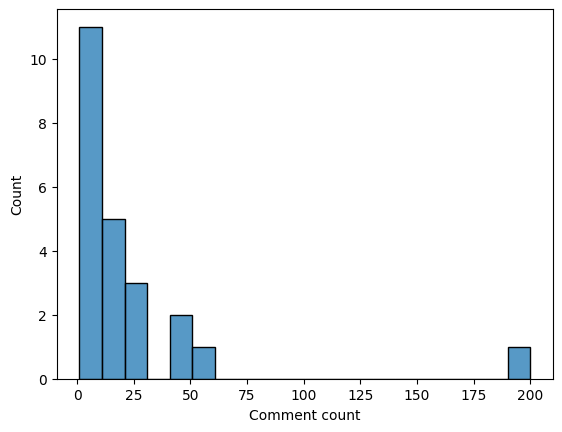

In [89]:
sns.histplot(comment_counts, bins=20)
plt.xlabel("Comment count")
plt.show()

In [35]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = spark.sparkContext.broadcast(SentimentIntensityAnalyzer())

In [41]:
def get_comment_score(comments):
    sentiments = []
    upvotes = []
    
    if not comments: # empty
        return float(0)
    for comment in comments:
        sentiments.append(analyzer.value.polarity_scores(comment.comm_body)['compound'])
        upvotes.append(comment.comm_score if comment.comm_score > 0 else 0)
        
    return float(np.mean(np.array(sentiments) * np.array(upvotes) / (np.sum(upvotes) + 1e-12)))

def get_post_score(title):
    return float(analyzer.value.polarity_scores(title)['compound'])

In [42]:
comment_sentiment_udf = udf(get_comment_score, DoubleType())
post_sentiment_udf = udf(get_post_score, DoubleType())

df_with_sentiment = df_reddit.withColumn("comments_sentiment", comment_sentiment_udf(col("comments")))
df_with_sentiment = df_with_sentiment.withColumn("post_sentiment", post_sentiment_udf(col("post_title")))

df_with_sentiment.show()

+--------------------+-------+----------+-------------+--------------------+-----------+--------------------+--------------+
|            comments|post_id|post_score|    post_time|          post_title|post_upvote|  comments_sentiment|post_sentiment|
+--------------------+-------+----------+-------------+--------------------+-----------+--------------------+--------------+
|[{[deleted], m5s1...|1hvcb47|       108|1.736203692E9|I want to invest ...|       0.73|2.004197080291970...|        0.0772|
|                  []|1hvb71c|         0|1.736200836E9|Phantom wallet ap...|        0.5|                 0.0|           0.0|
|[{Invest 120k and...|1hvb6q0|        27|1.736200816E9|Over 3 years in c...|       0.65|-0.00263026755852...|        0.0258|
|[{The best way I ...|1hv8vhg|        53|1.736195175E9|Explaine to me pr...|        0.9|0.016132477064220038|        0.6369|
|[{Don't fomo into...|1hv8aba|        10|1.736193783E9|      New to crypto!|       0.75|0.023582948717948114|           0.0|


In [43]:
comment_sentiments = np.array(df_with_sentiment.select("comments_sentiment").rdd.flatMap(lambda x: x).collect())
post_sentiments = np.array(df_with_sentiment.select("post_sentiment").rdd.flatMap(lambda x: x).collect())

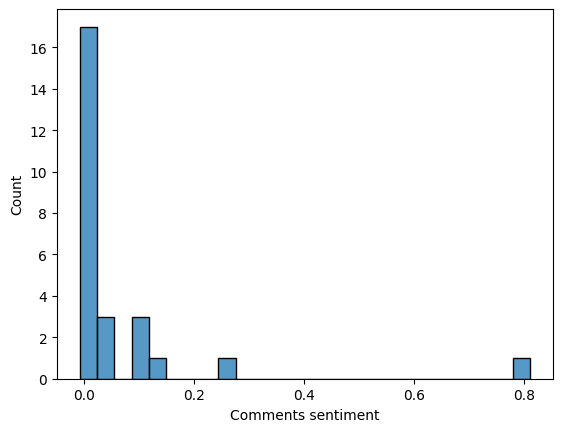

In [83]:
sns.histplot(comment_sentiments)
plt.xlabel("Comments sentiment")
plt.show()

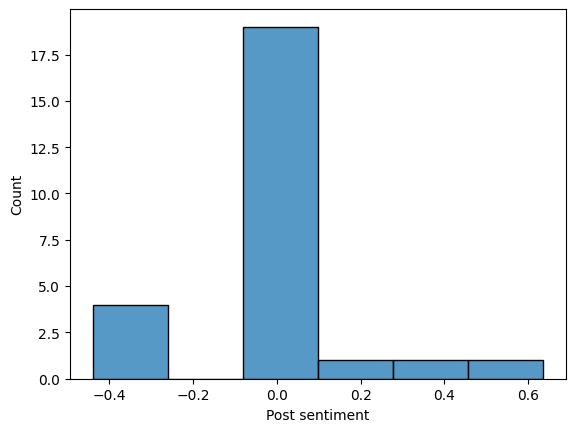

In [82]:
sns.histplot(post_sentiments)
plt.xlabel("Post sentiment")
plt.show()

In [71]:
comment_upvotes = np.array(df_exploded.select(col("comment.comm_score")).rdd.flatMap(lambda x: x).collect())
comment_upvotes = np.sort(comment_upvotes)[::-1]

In [73]:
comment_upvotes

array([765, 696, 266,  43,  42,  41,  39,  38,  37,  31,  31,  31,  26,
        22,  21,  21,  21,  20,  19,  18,  15,  15,  15,  14,  13,  13,
        12,  10,  10,  10,  10,   9,   9,   9,   9,   9,   9,   9,   8,
         8,   8,   8,   8,   8,   8,   7,   7,   7,   7,   7,   7,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   5,   5,   5,
         5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   1,   

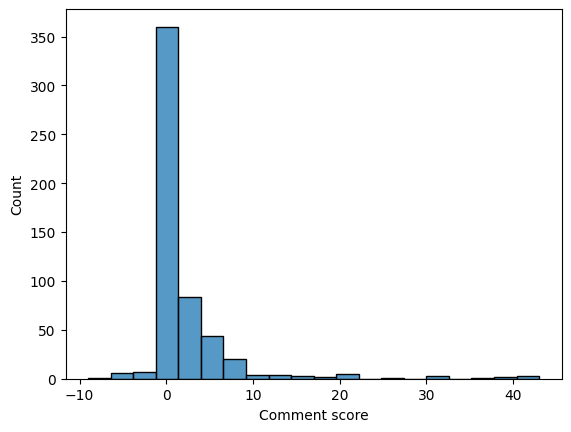

In [81]:
sns.histplot(comment_upvotes[3:], bins=20)
plt.xlabel("Comment score")
plt.show()

In [133]:
df_weather.show()

+------+-------------------+----------+--------------------+--------+--------------------+----------+--------------------+-------------------+
|clouds|              coord|        dt|                main|    name|                 sys|visibility|             weather|               wind|
+------+-------------------+----------+--------------------+--------+--------------------+----------+--------------------+-------------------+
|   {4}| {51.5085, -0.1257}|1736290018|{270.88, 999, 90,...|  London|{GB, 268730, 1736...|     10000|[{clear sky, 01n,...|   {230, null, 3.6}|
|   {0}| {40.7143, -74.006}|1736290182|{264.92, 1012, 51...|New York|{US, 2008776, 173...|     10000|[{clear sky, 01n,...|{310, 18.01, 10.29}|
|   {0}|  {48.8534, 2.3488}|1736289670|{277.07, 997, 86,...|   Paris|{FR, 2012208, 173...|     10000|[{light rain, 10n...|  {220, null, 2.57}|
|  {20}|{35.6895, 139.6917}|1736290239|{274.13, 1007, 40...|   Tokyo|{JP, 268395, 1736...|     10000|[{few clouds, 02d...|   {240, null, 7.2}|

In [108]:
df_weather.printSchema()

root
 |-- clouds: struct (nullable = true)
 |    |-- all: long (nullable = true)
 |-- coord: struct (nullable = true)
 |    |-- lat: double (nullable = true)
 |    |-- lon: double (nullable = true)
 |-- dt: long (nullable = true)
 |-- main: struct (nullable = true)
 |    |-- feels_like: double (nullable = true)
 |    |-- grnd_level: long (nullable = true)
 |    |-- humidity: long (nullable = true)
 |    |-- pressure: long (nullable = true)
 |    |-- sea_level: long (nullable = true)
 |    |-- temp: double (nullable = true)
 |    |-- temp_max: double (nullable = true)
 |    |-- temp_min: double (nullable = true)
 |-- name: string (nullable = true)
 |-- sys: struct (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- sunrise: long (nullable = true)
 |    |-- sunset: long (nullable = true)
 |    |-- type: long (nullable = true)
 |-- visibility: long (nullable = true)
 |-- weather: array (nullable = true)
 |    |-- element: struct (co

In [109]:
pd_weather = df_weather.select("main.humidity", "wind.speed", "main.pressure", "main.temp", "main.feels_like").toPandas()

In [115]:
df_weather.select("main.humidity", "wind.speed", "main.pressure", "main.temp", "main.feels_like").show()

+--------+-----+--------+------+----------+
|humidity|speed|pressure|  temp|feels_like|
+--------+-----+--------+------+----------+
|      90|  3.6|    1004|274.56|    270.88|
|      51|10.29|    1013|271.92|    264.92|
|      86| 2.57|    1007|279.06|    277.07|
|      40|  7.2|    1009|278.57|    274.13|
|      85|  3.6|    1004|277.15|    274.03|
|      90|  3.6|    1004|274.56|    270.88|
|      51|10.29|    1013|271.92|    264.92|
|      86| 2.57|    1007|279.06|    277.07|
|      40|  7.2|    1009|278.57|    274.13|
|      85|  3.6|    1004|277.15|    274.03|
|      90|  3.6|    1004|274.56|    270.88|
|      51|10.29|    1013|271.92|    264.92|
|      86| 2.57|    1007|279.06|    277.07|
|      40|  7.2|    1009|278.57|    274.13|
|      85|  3.6|    1004|277.15|    274.03|
+--------+-----+--------+------+----------+



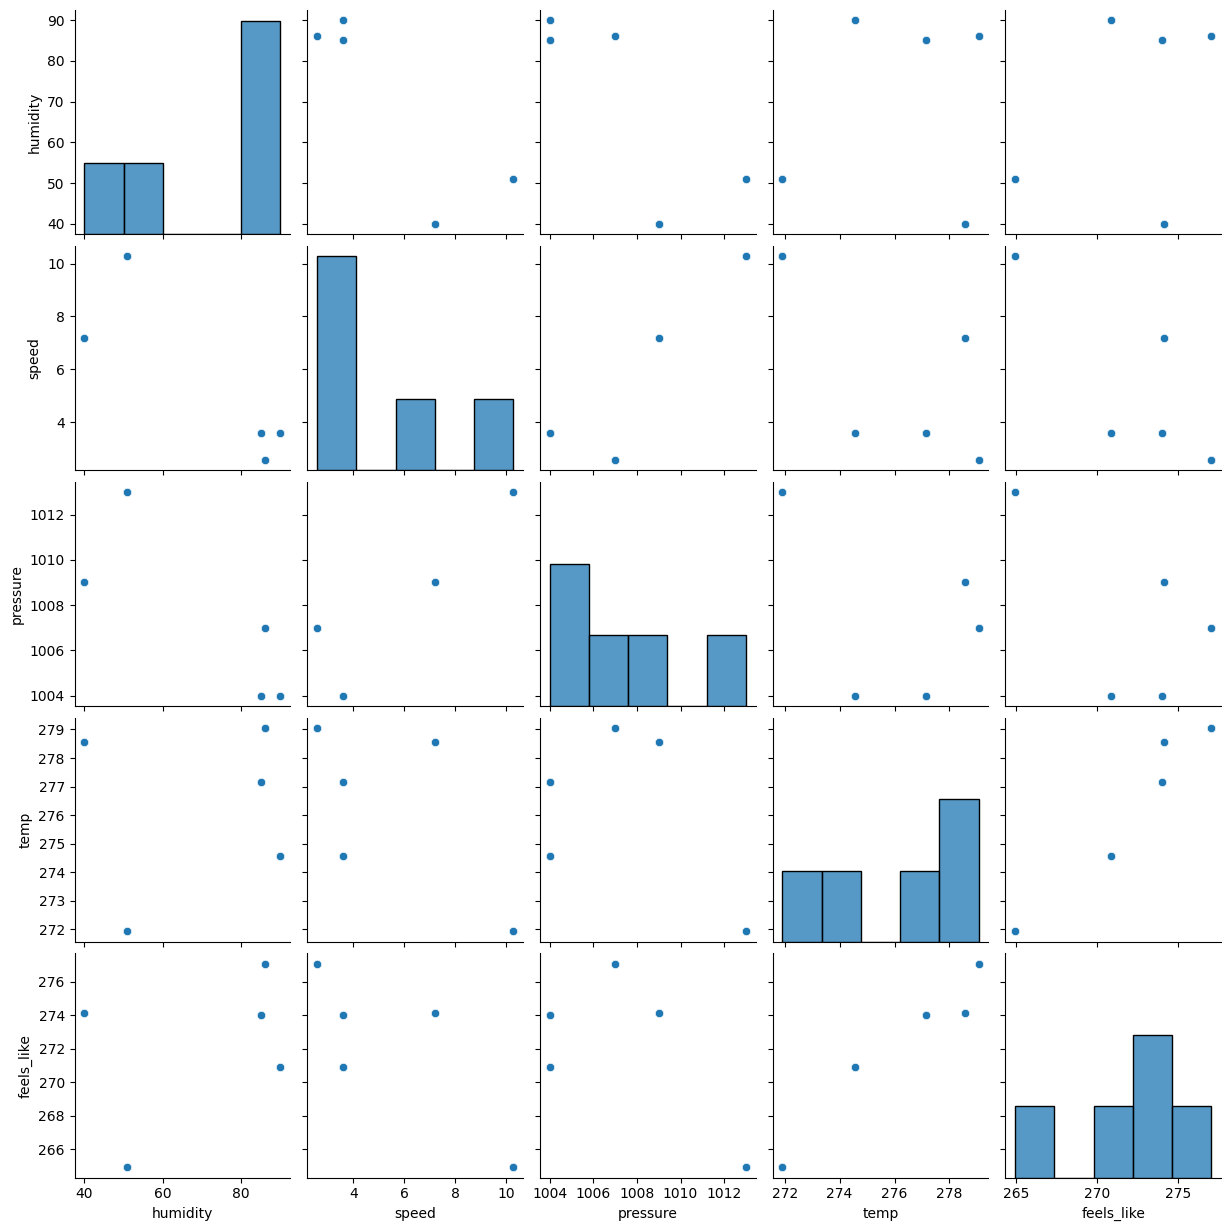

In [116]:
sns.pairplot(pd_weather)
